# Data Generation Tests


In [1]:

import sys
import pathlib
current_path = pathlib.Path().absolute()
root_path = "{0}\\..".format(current_path)
sys.path.append("{0}\\src".format(root_path))

import cv2
import os
import tensorflow as tf
import utils.config as cfg
import utils.segmentation_data_generator as gen

### Setup
#### Config import
Firstly, we import the configuration information from a given path through the use of Config class.

In [2]:
config_path = "../config/segmentation_poles.json"

config = cfg.Config(config_path)
config.summarize()

{'input_shape': [None, None, 3], 'n_classes': 4, 'name': 'resnet50_unet_fullVertAndRand_ks1bridge_lr1e4_freeze0', 'model': 'dynamic_unet', 'train': <utils.config.TrainConfig object at 0x00000254D3085608>, 'eval': <utils.config.EvalConfig object at 0x00000254D3085588>, 'model_params': <utils.config.ModelParamsConfig object at 0x00000254D3085688>, 'image_data_generator': None}


#### Image+Mask generators
The following functions allow the creation of two ImageDataGenerator, more specifically it returns
two DirectoryIterators (flow_from_directory) which emit the input Image (h, w, 3-channels) and the 
(grayscale) Input Mask (h, w)

In [3]:
def create_image_data_generator(image_generator_config):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=image_generator_config.featurewise_center,
        featurewise_std_normalization=image_generator_config.featurewise_std_normalization,
        rotation_range=image_generator_config.rotation_range,
        width_shift_range=image_generator_config.width_shift_range,
        horizontal_flip=image_generator_config.horizonal_flip,
        height_shift_range=image_generator_config.height_shift_range,
        zoom_range=image_generator_config.zoom_range,
        fill_mode="nearest",
        rescale=1./255
    )


def create_mask_data_generator(image_generator_config):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=image_generator_config.rotation_range,
        width_shift_range=image_generator_config.width_shift_range,
        horizontal_flip=image_generator_config.horizonal_flip,
        height_shift_range=image_generator_config.height_shift_range,
        zoom_range=image_generator_config.zoom_range,
        fill_mode="nearest",
    )

def generate_directory_datagen(config: cfg.Config, x_path, y_path, x=None, classes=None):
    seed = 33

    train_datagen = create_image_data_generator(
        config.train.image_data_generator
    )
    y_config = config.train.image_data_generator
    y_config.featurewise_center = False
    y_config.featurewise_std_normalization = False
    y_train_datagen = create_mask_data_generator(
        y_config
    )
    target_size = config.input_shape
    if target_size[0] is None and target_size[1] is None:
        target_size = (1024, 1024)
    else:
        target_size = (target_size[0], target_size[1])

    train_gen = train_datagen.flow_from_directory(x_path, batch_size=config.train.batch_size, seed=seed,
                                                  target_size=target_size,
                                                  classes=classes,
                                                  class_mode=None)
    train_y_gen = y_train_datagen.flow_from_directory(y_path, batch_size=config.train.batch_size, seed=seed,
                                                      target_size=target_size,
                                                      color_mode="grayscale", classes=classes,
                                                      class_mode=None)

    return train_gen, train_y_gen

### Pack generators into segmentation data generator

`SegmentationDataGenerator` class allows to flow tuples of image+masks together as input to a CNN.


In [4]:
train_images_path = r"C:\Users\dadem\Desktop\poles_dataset\images"
train_masks_path = r"C:\Users\dadem\Desktop\poles_dataset\labels"
x, y = generate_directory_datagen(config, 
                                  train_images_path,
                                  train_masks_path,
                                  classes=config.train.classes)

segmentation_generator = gen.SegmentationDataGenerator(x, y, slicing_rate=0.7)
i=0

Found 2783 images belonging to 1 classes.
Found 2783 images belonging to 1 classes.


(1024, 1024, 3)
(1024, 1024)


C:\ProgramData\Anaconda3\envs\tf2_env\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


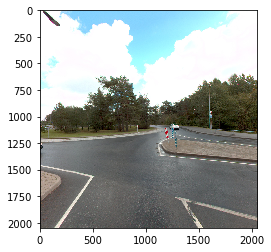

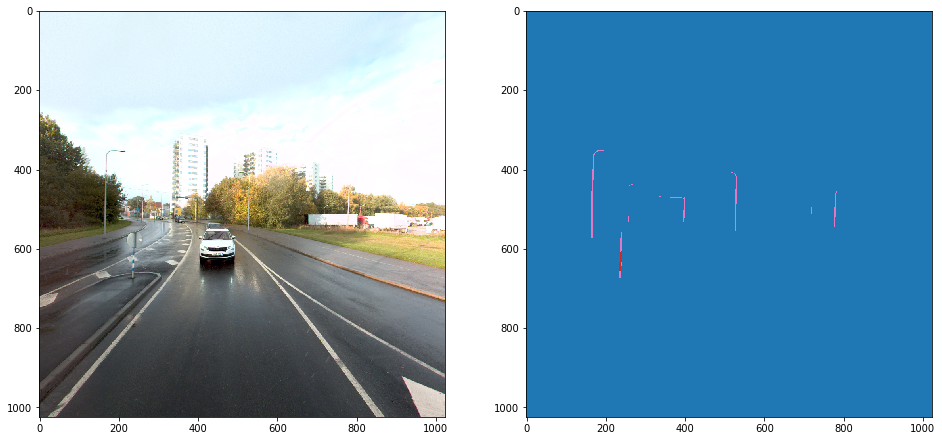

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpl_image
batch = segmentation_generator[i]
image_name, mask_name = segmentation_generator.get_items_names(i)
# orig = mpl_image.imread(os.path.join(train_images_path, image_name))
# plt.imshow(orig)
image = batch[0][0]
mask = batch[1][0][:, :, 0]
print(image.shape)
print(mask.shape)


def visualize_image_and_mask(img, msk):
    figure = plt.figure(figsize=(16, 8))
    ax1 = figure.add_subplot(121)
    ax1.imshow(img)
    ax2 = figure.add_subplot(122)
    ax2.imshow(msk, cmap="tab10", vmax=3)
    figure.show()
    
visualize_image_and_mask(image, mask)
i += 1

In [25]:
print(mask.max() == 0.0)



False
